# Weighted Least Square regression (Model 1)

This model produces the lowest scoring predictions based on RMSE.

Loading the needed libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy import special
import statsmodels.api as sm

In [2]:
df = pd.read_csv("data/train.csv")

df.head()

Id  Type Zone  LotArea LotConfig BldgType HouseStyle  OverallQual   
0    6    60   RL     8317    Inside     1Fam     2Story            7  \
1  182    50   RM     6250    Inside     1Fam     1.5Sto            7   
2  468    45   RM     7135    Inside     1Fam     1.5Sto            7   
3  512   120   RM     4032    Inside   TwnhsE     1Story            5   
4  600    20   RL    11313    Inside     1Fam     1Story            8   

   OverallCond  YearBuilt  ...  GarageFinish GarageCars GarageArea GarageQual   
0            5       2002  ...           RFn          2        553         TA  \
1            5       1931  ...           Unf          2        458         Fa   
2            7       1930  ...           Unf          1        285         TA   
3            7       1971  ...           Unf          2        544         TA   
4            5       2007  ...           RFn          3        803         TA   

  GarageCond PoolArea MoSold YrSold SaleCondition  SalePrice  
0         TA        0      2   2007        Normal     196327  
1         TA        0      4   2008       Abnorml     124205  
2         TA        0      6   2006        Normal     104614  
3         TA        0      6   2007        Normal     143257  
4         TA        0      5   2010        Normal     340750  

[5 rows x 45 columns]

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             500 non-null    int64 
 1   Type           500 non-null    int64 
 2   Zone           500 non-null    object
 3   LotArea        500 non-null    int64 
 4   LotConfig      500 non-null    object
 5   BldgType       500 non-null    object
 6   HouseStyle     500 non-null    object
 7   OverallQual    500 non-null    int64 
 8   OverallCond    500 non-null    int64 
 9   YearBuilt      500 non-null    int64 
 10  YearRemodAdd   500 non-null    int64 
 11  RoofStyle      500 non-null    object
 12  ExterQual      500 non-null    object
 13  ExterCond      500 non-null    object
 14  Foundation     500 non-null    object
 15  BsmtQual       487 non-null    object
 16  BsmtCond       487 non-null    object
 17  BsmtExposure   487 non-null    object
 18  BsmtRating     487 non-null   

## Missing values and encodings of categorical variables

In general, we see that only categorical variables have missing values. This data has missing values only for properties which lack a particular feature. Hence, the missing values are treated as a separate category and endoded as 0 so when a property misses a particular feature, the information is captured in the intercept.

In [4]:
nan_count = df.isna().sum()
print(nan_count)

Id                 0
Type               0
Zone               0
LotArea            0
LotConfig          0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          13
BsmtCond          13
BsmtExposure      13
BsmtRating        13
BsmtSF             0
CentralAir         0
X1stFlrSF          0
X2ndFlrSF          0
LowQualSF          0
LivAreaSF          0
FullBath           0
HalfBath           0
Bedrooms           0
Kitchen            0
KitchenQual        0
TotRms             0
Functional         0
Fireplaces         0
FireplaceQu      242
GarageType        33
GarageFinish      33
GarageCars         0
GarageArea         0
GarageQual        33
GarageCond        33
PoolArea           0
MoSold             0
YrSold             0
SaleCondition      0
SalePrice          0
dtype: int64


In [5]:
df['Type'] = df['Type'].astype('object')

In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int','float']).columns.tolist()

In [7]:
df[categorical_cols] = df[categorical_cols].fillna(value='A1')

Based on the unique values in the categorical columns, mapping for these is created in order to encode them to numerical levels.

In [8]:
# Print the unique values in categorical columns
for col in categorical_cols:
    df[col] = df[col].astype('category')
    unique_values = df[col].unique()
    print("Unique values in", col, ":", unique_values)

Unique values in Type : [60, 50, 45, 120, 20, ..., 75, 70, 85, 180, 40]
Length: 15
Categories (15, int64): [20, 30, 40, 45, ..., 120, 160, 180, 190]
Unique values in Zone : ['RL', 'RM', 'FV', 'C', 'RH']
Categories (5, object): ['C', 'FV', 'RH', 'RL', 'RM']
Unique values in LotConfig : ['Inside', 'CulDSac', 'Corner', 'FR2']
Categories (4, object): ['Corner', 'CulDSac', 'FR2', 'Inside']
Unique values in BldgType : ['1Fam', 'TwnhsE', 'Duplex', 'Twnhs']
Categories (4, object): ['1Fam', 'Duplex', 'Twnhs', 'TwnhsE']
Unique values in HouseStyle : ['2Story', '1.5Sto', '1Story', '2.5Sto']
Categories (4, object): ['1.5Sto', '1Story', '2.5Sto', '2Story']
Unique values in RoofStyle : ['Gable', 'Hip', 'Flat']
Categories (3, object): ['Flat', 'Gable', 'Hip']
Unique values in ExterQual : ['Gd', 'TA', 'Fa', 'Ex']
Categories (4, object): ['Ex', 'Fa', 'Gd', 'TA']
Unique values in ExterCond : ['TA', 'Gd', 'Fa', 'Ex']
Categories (4, object): ['Ex', 'Fa', 'Gd', 'TA']
Unique values in Foundation : ['PConc',

In [9]:
mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'A1':0}

df['ExterQual'] = df['ExterQual'].map(mapping).replace(mapping).astype('int') # Using map() function
df['ExterCond'] = df['ExterCond'].map(mapping).replace(mapping).astype('int') # Using map() function
df['BsmtQual'] = df['BsmtQual'].map(mapping).replace(mapping).astype('int') # Using map() function
df['BsmtCond'] = df['BsmtCond'].map(mapping).replace(mapping).astype('int') # Using map() function
df['FireplaceQu'] = df['FireplaceQu'].map(mapping).replace(mapping).astype('int') # Using map() function
df['GarageQual'] = df['GarageQual'].map(mapping).replace(mapping).astype('int') # Using map() function
df['GarageCond'] = df['GarageCond'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Ex': 3, 'Gd': 2, 'TA': 1, 'Fa': 0}

df['KitchenQual'] = df['KitchenQual'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'A1': 0}

df['BsmtExposure'] = df['BsmtExposure'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'A1': 0}

df['BsmtRating'] = df['BsmtRating'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Typ': 3, 'Min': 2, 'Mod': 1, 'Maj': 0}

df['Functional'] = df['Functional'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Fin': 1, 'RFn': 1, 'Unf': 0, 'A1': 0}

df['GarageFinish'] = df['GarageFinish'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Y': 1, 'N': 0}

df['CentralAir'] = df['CentralAir'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Attchd': 1, 'Other': 1, 'Detchd': 0, 'A1': 0}

df['GarageType'] = df['GarageType'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Abnorml': 1, 'Family': 0, 'Normal': 0}

df['SaleCondition_Abnorml'] = df['SaleCondition'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Abnorml': 0, 'Family': 1, 'Normal': 0}

df['SaleCondition_Family'] = df['SaleCondition'].map(mapping).replace(mapping).astype('int') # Using map() function

df.drop('SaleCondition', axis=1, inplace=True)

Creating dummies for certain features of the properties which might be useful for further interaction effetcs.

In [10]:
df['HasBsmt'] = df['BsmtSF'].apply(lambda con: False if con == 0 else True).astype('int')
df['HasGarage'] = df['GarageCars'].apply(lambda con: False if con == 0 else True).astype('int')
df['HasFireplace'] = df['Fireplaces'].apply(lambda con: False if con == 0 else True).astype('int')
df['HasPool'] = df['PoolArea'].apply(lambda con: False if con == 0 else True).astype('int')

## Visual inspection of patterns in the data

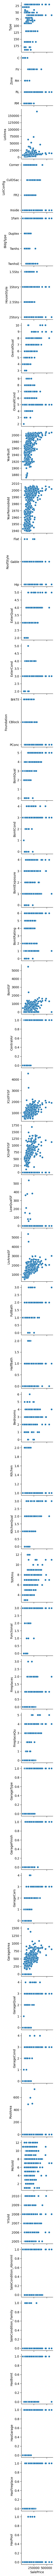

In [11]:
sns.pairplot(df.drop('Id', axis=1), y_vars=df.columns.drop(['SalePrice','Id']), x_vars=['SalePrice'])

Due to the high correlations among the possible regressors, some numerical variables, that are assumed to be important, are going to be combined in order to reduce dimensionality of the data.

In [12]:
df['YearBuiltandRemod'] = df['YearBuilt'] + df['YearRemodAdd']
df['NewArea'] = df['BsmtSF'] + df['X1stFlrSF'] + df['X2ndFlrSF']

From the plot above, we see that there are some non-linear patterns in the data. For this reason, box-cox transformation is going to be used in order to normalise the data and make the patterns more linear. Box-cox is also applied to the response variable and for every variable, an optimal lambda is used such that the distributions approach normal distribution.

In [13]:
df['SalePrice'], _ = stats.boxcox(df['SalePrice'])
response_lambda = _

In [14]:
num_cols_tranform = ['LotArea','BsmtSF','X1stFlrSF', 'X2ndFlrSF', 'LivAreaSF', 'GarageArea', 'NewArea']

lambdas = []
for i in num_cols_tranform:
    df[i], _ = stats.boxcox(df[i]+1)
    lambdas.append(_)

In [15]:
numerical_cols_plot = numerical_cols[0:22] + ['YearBuiltandRemod','NewArea']

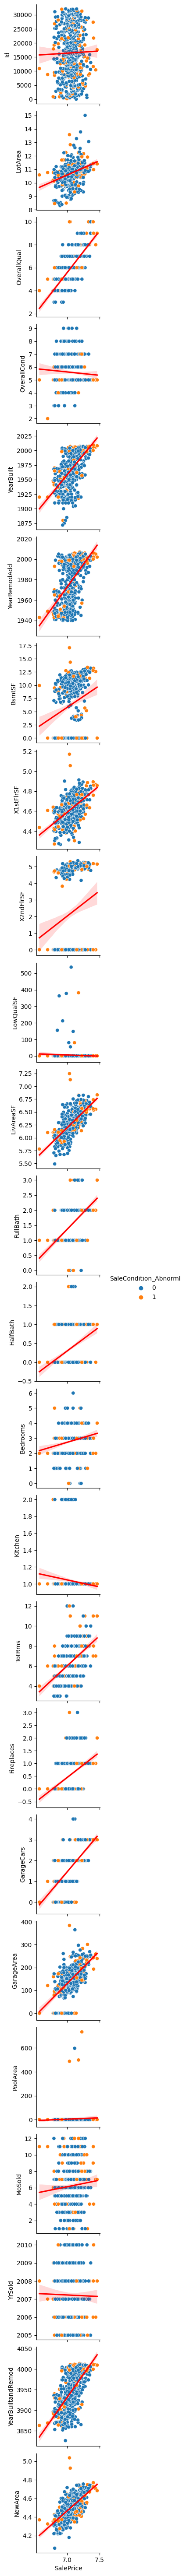

In [16]:
g=sns.pairplot(df[numerical_cols_plot+['SalePrice','SaleCondition_Abnorml']], y_vars=numerical_cols_plot, x_vars=['SalePrice'],hue='SaleCondition_Abnorml')
# Add regression line to each scatter plot
for ax in g.axes.flat:
    if ax.get_ylabel() in numerical_cols_plot:
        sns.regplot(x=ax.get_xlabel(), y=ax.get_ylabel(), data=df[numerical_cols_plot+['SalePrice','SaleCondition_Abnorml']], ax=ax, scatter=False, color='red', ci=95)

# Display the plot
plt.show()

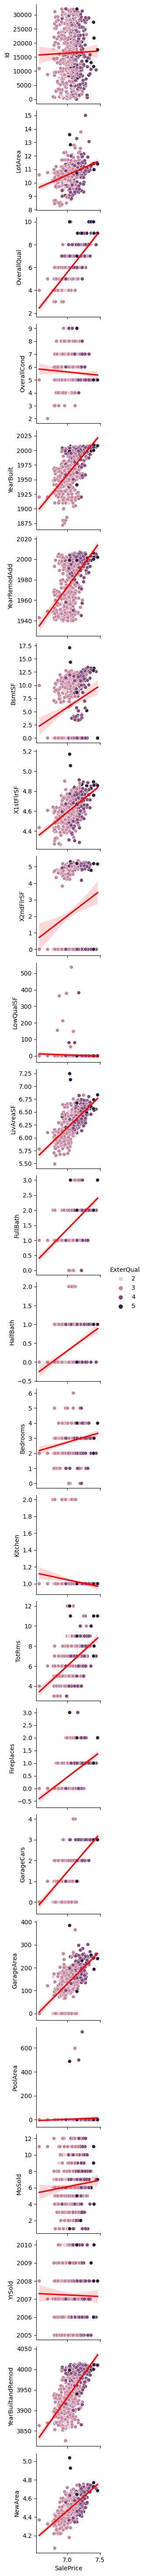

In [17]:
g=sns.pairplot(df[numerical_cols_plot+['SalePrice','ExterQual']], y_vars=numerical_cols_plot, x_vars=['SalePrice'],hue='ExterQual')
# Add regression line to each scatter plot
for ax in g.axes.flat:
    if ax.get_ylabel() in numerical_cols_plot:
        sns.regplot(x=ax.get_xlabel(), y=ax.get_ylabel(), data=df[numerical_cols_plot+['SalePrice','ExterQual']], ax=ax, scatter=False, color='red', ci=95)

# Display the plot
plt.show()

From the plots above, we see that the abnormal sale condition catches some outliers when it comes to the effects of NewArea and OverallQual. Moreover, we that ExterQual can be used for similar interactions.

In [18]:
categorical_cols = df.select_dtypes(include=['category']).columns.tolist()

In [19]:
# Create dummy variables for categorical variable
df_model_dummies = pd.get_dummies(df, columns=categorical_cols)

# Compute the correlation matrix
corr_dummy = df_model_dummies.corr().round(decimals=2)

[Text(0.5, 0, 'Id'),
 Text(1.5, 0, 'LotArea'),
 Text(2.5, 0, 'OverallQual'),
 Text(3.5, 0, 'OverallCond'),
 Text(4.5, 0, 'YearBuilt'),
 Text(5.5, 0, 'YearRemodAdd'),
 Text(6.5, 0, 'ExterQual'),
 Text(7.5, 0, 'ExterCond'),
 Text(8.5, 0, 'BsmtQual'),
 Text(9.5, 0, 'BsmtCond'),
 Text(10.5, 0, 'BsmtExposure'),
 Text(11.5, 0, 'BsmtRating'),
 Text(12.5, 0, 'BsmtSF'),
 Text(13.5, 0, 'CentralAir'),
 Text(14.5, 0, 'X1stFlrSF'),
 Text(15.5, 0, 'X2ndFlrSF'),
 Text(16.5, 0, 'LowQualSF'),
 Text(17.5, 0, 'LivAreaSF'),
 Text(18.5, 0, 'FullBath'),
 Text(19.5, 0, 'HalfBath'),
 Text(20.5, 0, 'Bedrooms'),
 Text(21.5, 0, 'Kitchen'),
 Text(22.5, 0, 'KitchenQual'),
 Text(23.5, 0, 'TotRms'),
 Text(24.5, 0, 'Functional'),
 Text(25.5, 0, 'Fireplaces'),
 Text(26.5, 0, 'FireplaceQu'),
 Text(27.5, 0, 'GarageType'),
 Text(28.5, 0, 'GarageFinish'),
 Text(29.5, 0, 'GarageCars'),
 Text(30.5, 0, 'GarageArea'),
 Text(31.5, 0, 'GarageQual'),
 Text(32.5, 0, 'GarageCond'),
 Text(33.5, 0, 'PoolArea'),
 Text(34.5, 0, 'MoSol

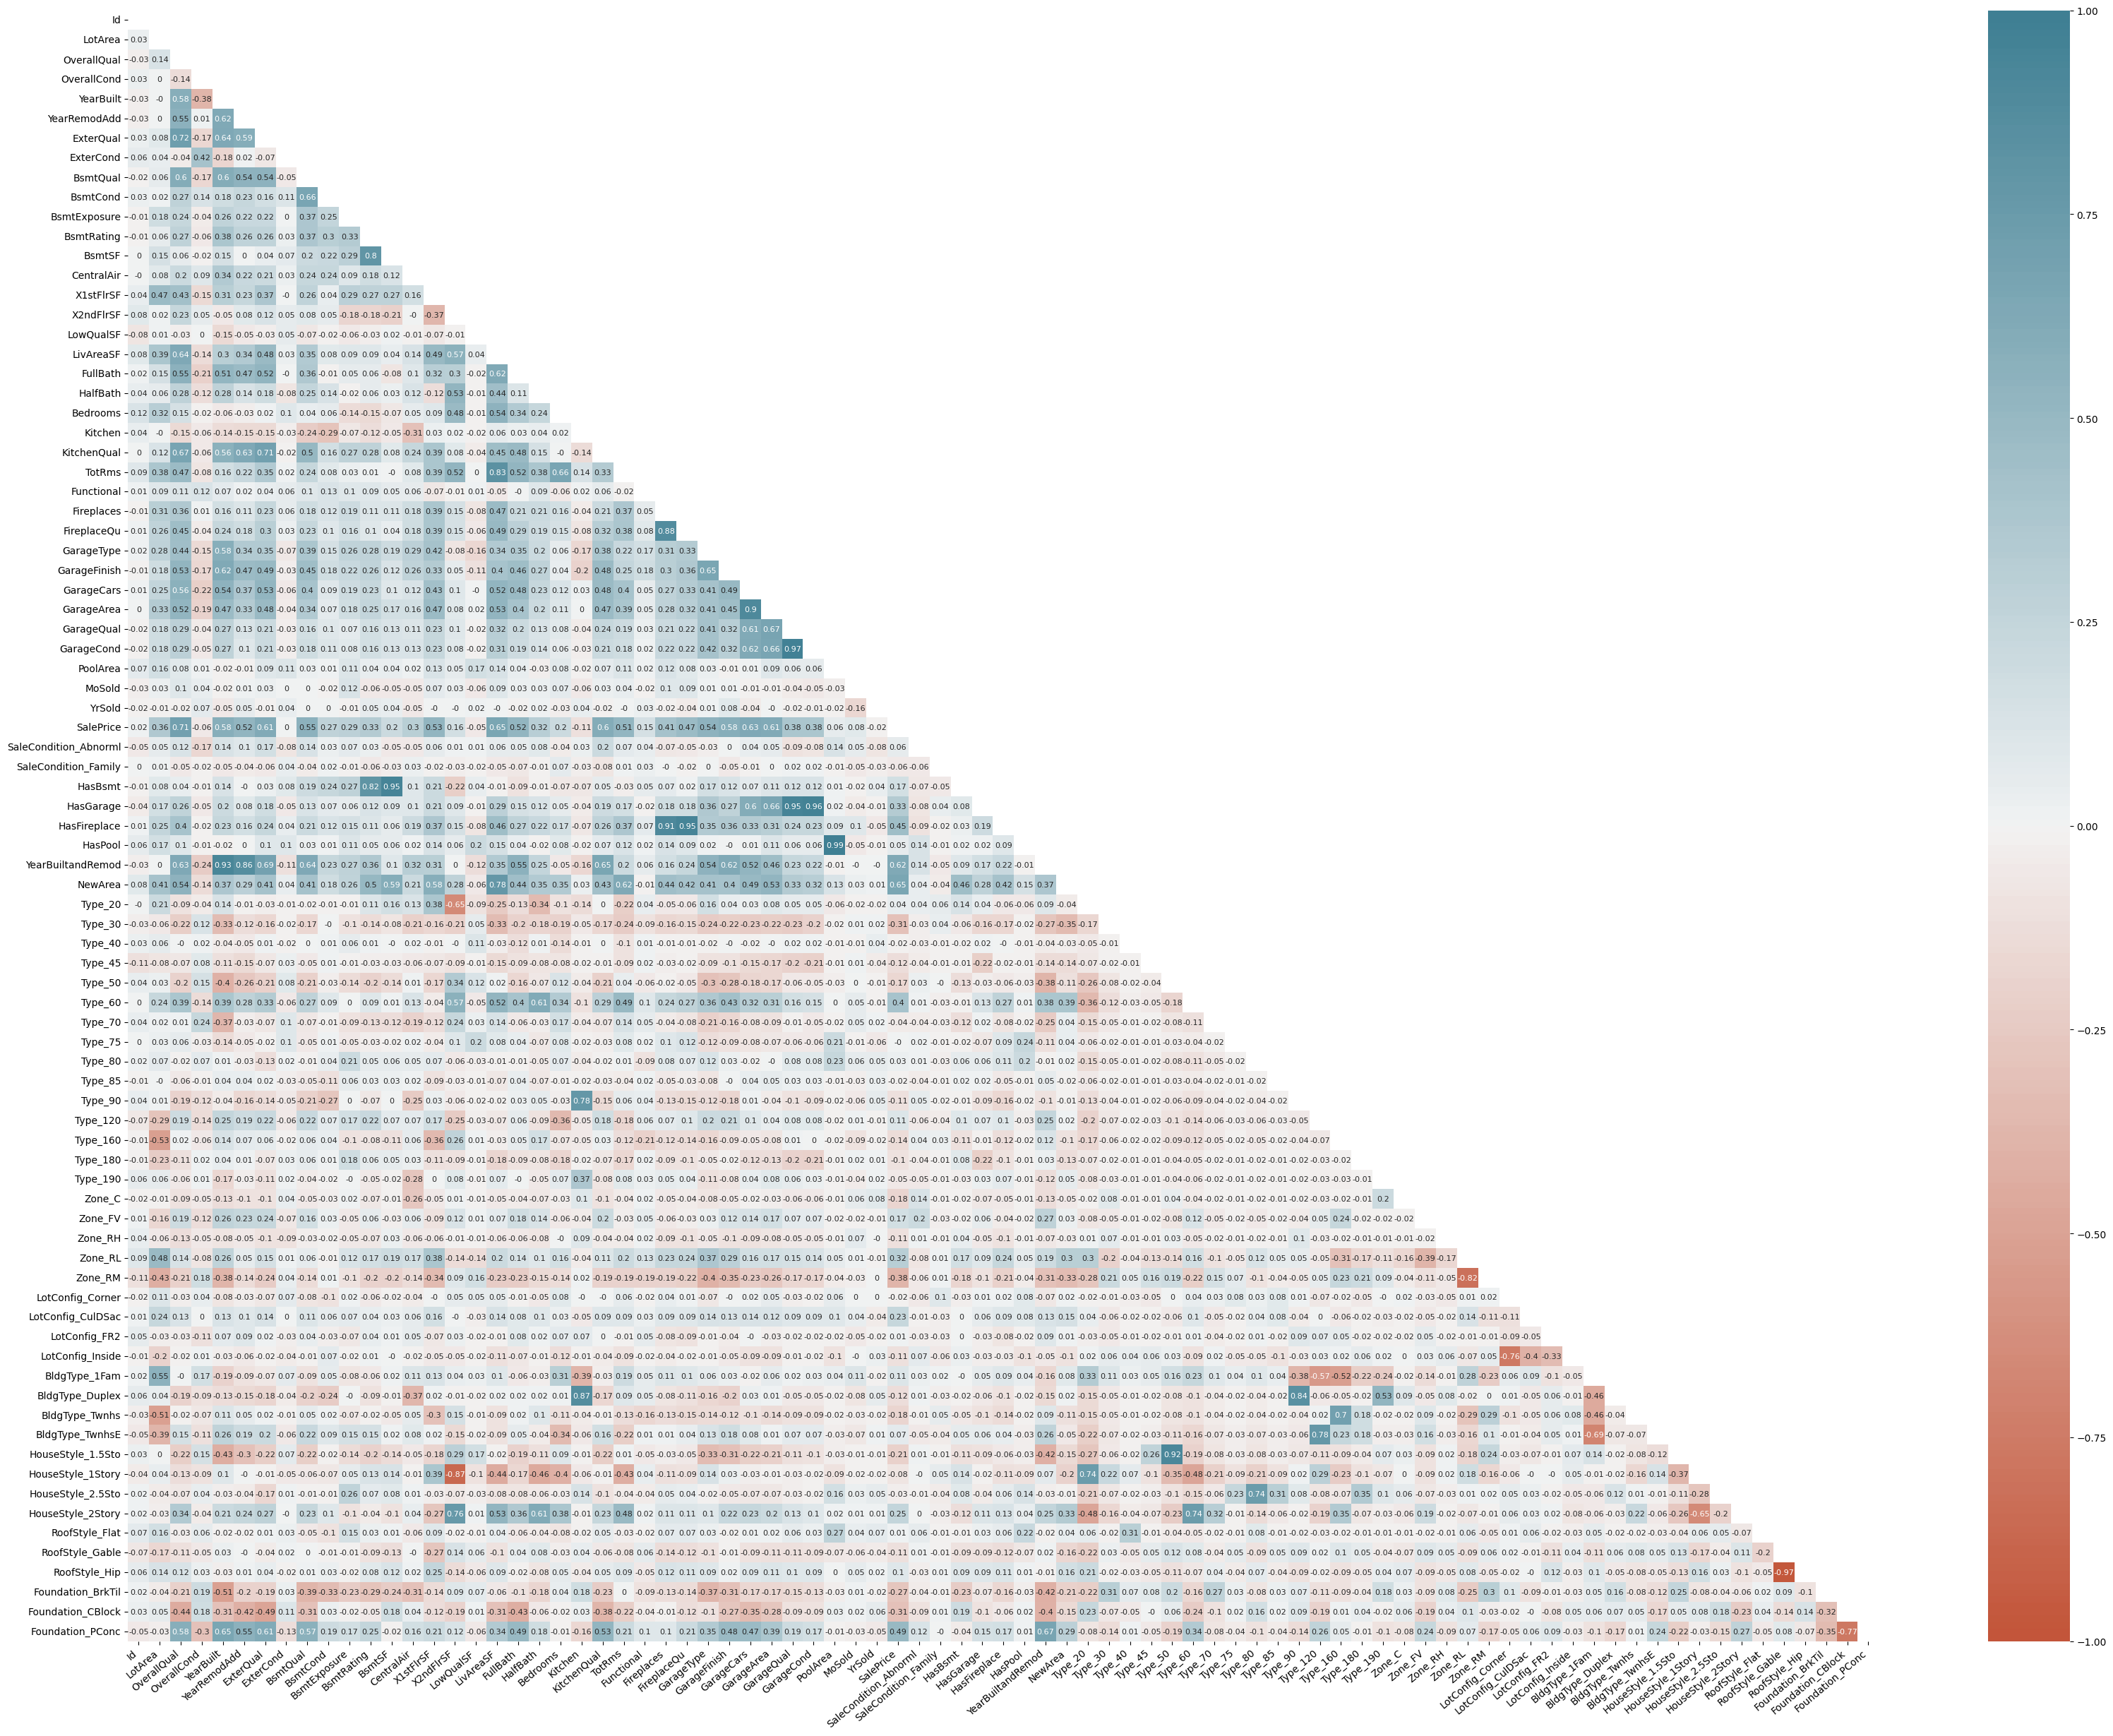

In [20]:
mask = np.zeros_like(corr_dummy)
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix as a heatmap
plt.figure(figsize = (40,30))
# Set up the annotation font size
annot_font = {'fontsize': 8}
ax = sns.heatmap(corr_dummy, annot=True, vmin=-1, vmax=1, center=0, cbar=True, mask=mask, square=False,  annot_kws=annot_font,
            cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')

In [21]:
correlation_threshold = 0.8
highly_correlated_pairs = []

# Iterate over the correlation matrix
for i in range(len(corr_dummy.columns)):
    for j in range(i + 1, len(corr_dummy.columns)):
        if abs(corr_dummy.iloc[i, j]) >= correlation_threshold:
            pair = (corr_dummy.columns[i], corr_dummy.columns[j])
            highly_correlated_pairs.append(pair)
print(highly_correlated_pairs)

[('YearBuilt', 'YearBuiltandRemod'), ('YearRemodAdd', 'YearBuiltandRemod'), ('BsmtRating', 'BsmtSF'), ('BsmtRating', 'HasBsmt'), ('BsmtSF', 'HasBsmt'), ('X2ndFlrSF', 'HouseStyle_1Story'), ('LivAreaSF', 'TotRms'), ('Kitchen', 'BldgType_Duplex'), ('Fireplaces', 'FireplaceQu'), ('Fireplaces', 'HasFireplace'), ('FireplaceQu', 'HasFireplace'), ('GarageCars', 'GarageArea'), ('GarageQual', 'GarageCond'), ('GarageQual', 'HasGarage'), ('GarageCond', 'HasGarage'), ('PoolArea', 'HasPool'), ('Type_50', 'HouseStyle_1.5Sto'), ('Type_90', 'BldgType_Duplex'), ('Zone_RL', 'Zone_RM'), ('RoofStyle_Gable', 'RoofStyle_Hip')]


From the correlation plot, the following numerical variables are chosen for the regression: 'OverallQual', 'NewArea', 'YearBuiltandRemod' 'GarageCars', 'BsmtQual', 'GarageFinish', 'KitchenQual', 'LotArea', 'OverallCond'.  'OverallCond' is chosen mainly due to the fact that it has small correlation with other variables which means it is supposed capture more new information. 'LotArea' is chosen because it captures additional information about area of the whole property that is not captured in 'NewArea'.

In order to avoid vast diffferences in the scales of the data, some variables need to be rescaled.

In [22]:
scaler = StandardScaler()
df_model_dummies[['YearBuilt','YearRemodAdd','GarageArea','YearBuiltandRemod']] = scaler.fit_transform(df_model_dummies[['YearBuilt','YearRemodAdd','GarageArea','YearBuiltandRemod']])

In order to choose dummy variables that could be used in the model, a regression with only the numerical variables chosen above is going to be fitted and the residuals are going to be analyzed for further correlation.

In [23]:
y = df_model_dummies['SalePrice']
X = df_model_dummies.drop(['Id', 'SalePrice'], axis=1)

X[X.select_dtypes(include=['bool','category']).columns.tolist()] = X[X.select_dtypes(
    include=['bool','category']).columns.tolist()].astype(int) 

In [24]:
X = X[['NewArea','YearBuiltandRemod','GarageCars','BsmtQual','GarageFinish','KitchenQual','LotArea','OverallCond']]

X_train = X
y_train = y


In [25]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Print the p-values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     139.3
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          4.25e-121
Time:                        23:31:10   Log-Likelihood:                 617.83
No. Observations:                 500   AIC:                            -1218.
Df Residuals:                     491   BIC:                            -1180.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.2295      0.14

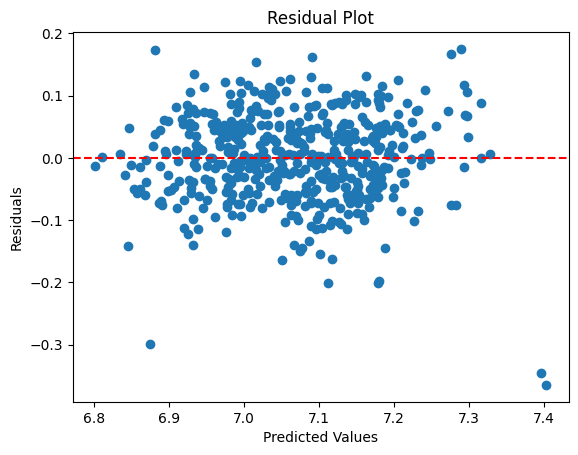

In [26]:
# Get the predicted values
y_pred_train = model.fittedvalues

# Calculate the residuals
residuals = model.resid

# Assuming 'y_pred' contains the predicted values and 'residuals' contains the residuals
plt.scatter(y_pred_train, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [27]:
reg_analysis = pd.DataFrame(df_model_dummies)
reg_analysis.loc[:, 'Residuals'] = residuals

In [28]:
# Compute the correlation matrix
corr_reg_analysis = reg_analysis.corr().round(decimals=2)

[Text(0.5, 0, 'Id'),
 Text(1.5, 0, 'LotArea'),
 Text(2.5, 0, 'OverallQual'),
 Text(3.5, 0, 'OverallCond'),
 Text(4.5, 0, 'YearBuilt'),
 Text(5.5, 0, 'YearRemodAdd'),
 Text(6.5, 0, 'ExterQual'),
 Text(7.5, 0, 'ExterCond'),
 Text(8.5, 0, 'BsmtQual'),
 Text(9.5, 0, 'BsmtCond'),
 Text(10.5, 0, 'BsmtExposure'),
 Text(11.5, 0, 'BsmtRating'),
 Text(12.5, 0, 'BsmtSF'),
 Text(13.5, 0, 'CentralAir'),
 Text(14.5, 0, 'X1stFlrSF'),
 Text(15.5, 0, 'X2ndFlrSF'),
 Text(16.5, 0, 'LowQualSF'),
 Text(17.5, 0, 'LivAreaSF'),
 Text(18.5, 0, 'FullBath'),
 Text(19.5, 0, 'HalfBath'),
 Text(20.5, 0, 'Bedrooms'),
 Text(21.5, 0, 'Kitchen'),
 Text(22.5, 0, 'KitchenQual'),
 Text(23.5, 0, 'TotRms'),
 Text(24.5, 0, 'Functional'),
 Text(25.5, 0, 'Fireplaces'),
 Text(26.5, 0, 'FireplaceQu'),
 Text(27.5, 0, 'GarageType'),
 Text(28.5, 0, 'GarageFinish'),
 Text(29.5, 0, 'GarageCars'),
 Text(30.5, 0, 'GarageArea'),
 Text(31.5, 0, 'GarageQual'),
 Text(32.5, 0, 'GarageCond'),
 Text(33.5, 0, 'PoolArea'),
 Text(34.5, 0, 'MoSol

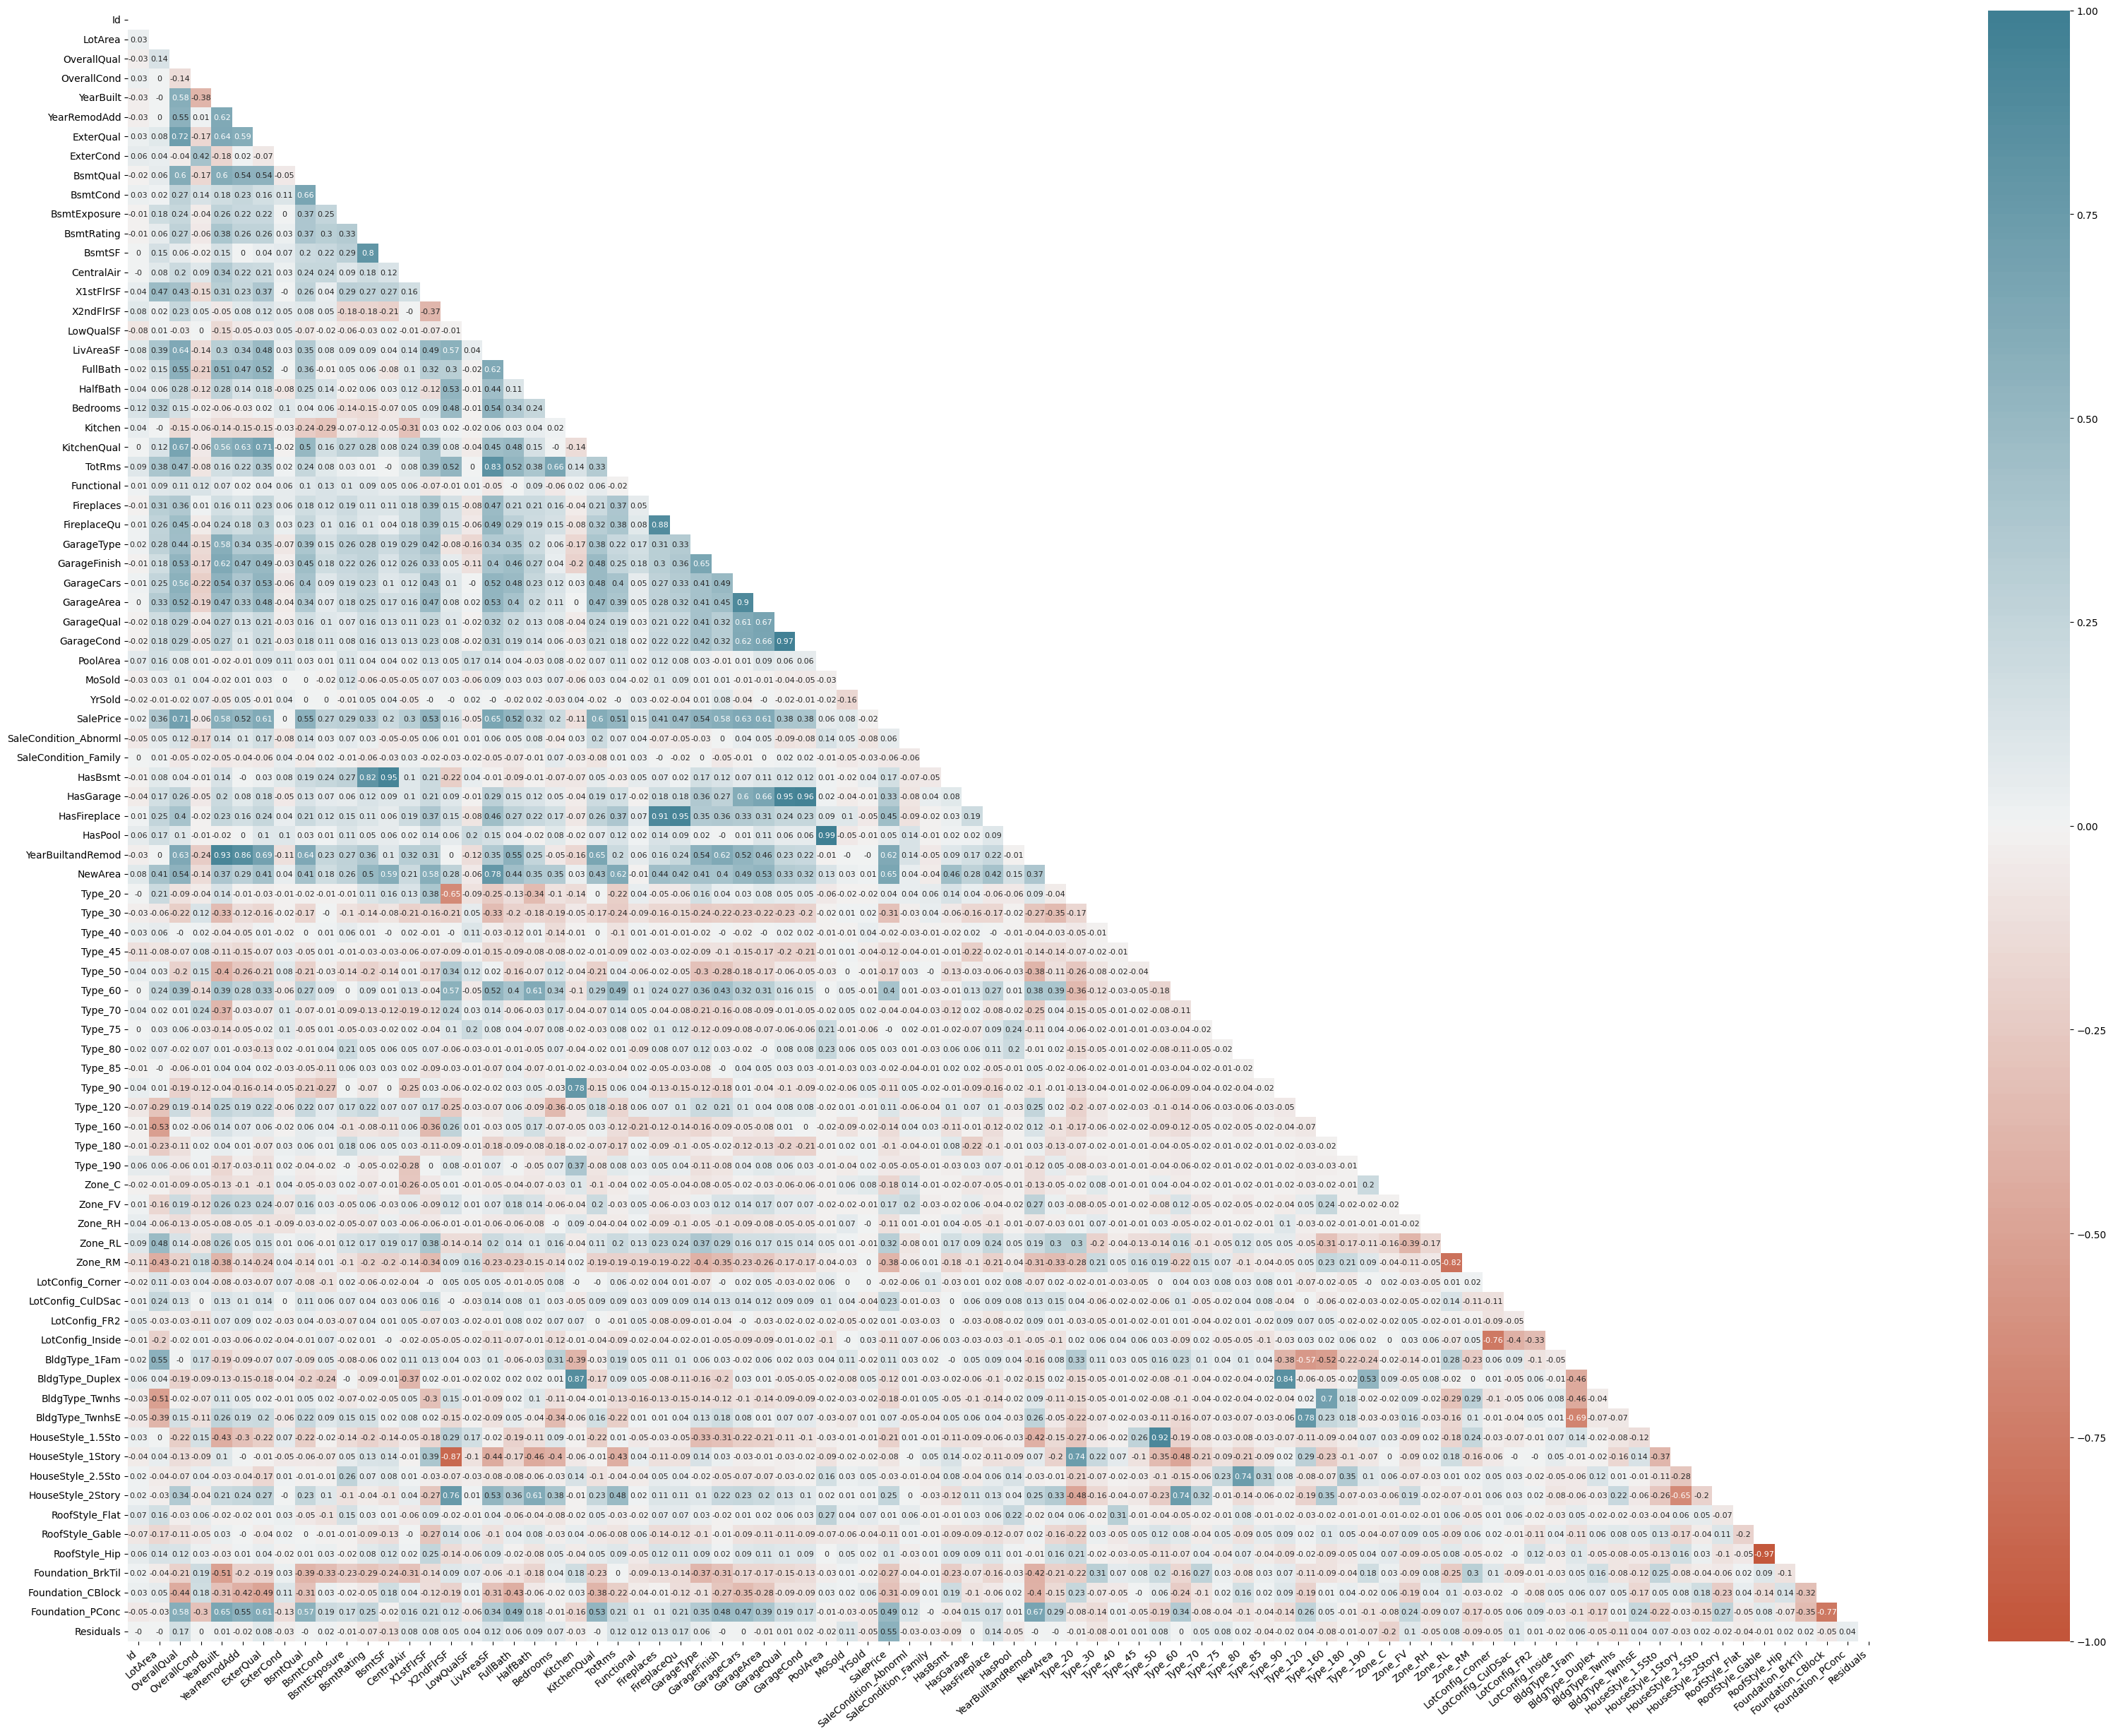

In [29]:
mask = np.zeros_like(corr_reg_analysis)
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix as a heatmap
plt.figure(figsize = (40,30))
# Set up the annotation font size
annot_font = {'fontsize': 8}
ax = sns.heatmap(corr_reg_analysis, annot=True, vmin=-1, vmax=1, center=0, cbar=True, mask=mask, square=False,  annot_kws=annot_font,
            cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')

Based on the correlations above, the following dummies are going to be included in the model: 'BldgType_Twnhs', 'Zone_RL', 'Zone_FV', 'LotConfig_Inside', 'FireplaceQu', 'Zone_C', 'Foundation_PConc'.

In order to fit the model, we need to create new variables for the interaction effects observed from the plots. Moreover, the two most extereme observations of SalePrice and NewArea at each tail are going to excluded from the model. This is due to the reason that we could observe in the plots that they inroduce large noise. 

In [30]:
y = df_model_dummies['SalePrice']
X = df_model_dummies.drop(['Id', 'SalePrice'], axis=1)

X[X.select_dtypes(include=['bool','category']).columns.tolist()] = X[X.select_dtypes(
    include=['bool','category']).columns.tolist()].astype(int) 

In [31]:
X['OverallQual:SaleCondition_Abnorml'] = X['OverallQual'] * X['SaleCondition_Abnorml'] 
X['NewArea:SaleCondition_Abnorml'] = X['NewArea'] * X['SaleCondition_Abnorml'] 
X['OverallQual:ExterQual'] = X['OverallQual'] * X['ExterQual'] 
X['NewArea:ExterQual'] = X['NewArea'] * X['ExterQual'] 

X = X[['NewArea','YearBuiltandRemod','GarageCars','BsmtQual','GarageFinish','KitchenQual','OverallCond','LotArea',
       'BldgType_Twnhs','Zone_RL','Zone_FV','LotConfig_Inside','FireplaceQu','Zone_C','Foundation_PConc',
       'OverallQual:SaleCondition_Abnorml','NewArea:SaleCondition_Abnorml','OverallQual:ExterQual','NewArea:ExterQual']]

X_train = X
y_train = y

X_train = X_train[(y_train>6.71) & (y_train<7.42)]
y_train = y_train[(y_train>6.71) & (y_train<7.42)]

y_train = y_train[(X_train['NewArea']>4.2) & (X_train['NewArea']<4.8)]
X_train = X_train[(X_train['NewArea']>4.2) & (X_train['NewArea']<4.8)]


In [32]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Print the p-values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     86.50
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          3.11e-140
Time:                        23:31:14   Log-Likelihood:                 705.26
No. Observations:                 492   AIC:                            -1371.
Df Residuals:                     472   BIC:                            -1287.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

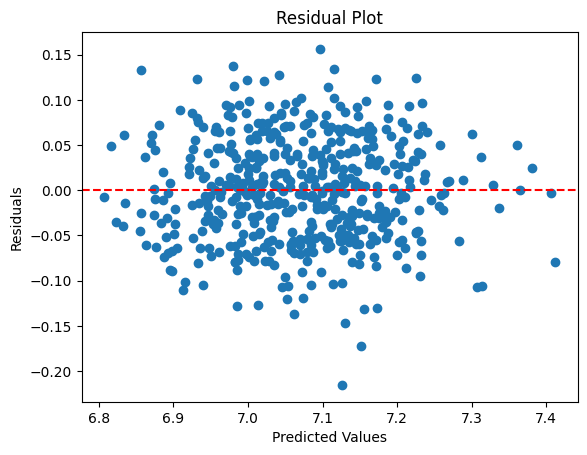

In [33]:
# Get the predicted values
y_pred_train = model.fittedvalues

# Calculate the residuals
residuals = model.resid

# Assuming 'y_pred' contains the predicted values and 'residuals' contains the residuals
plt.scatter(y_pred_train, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


From the residuals, we see that the variance is more or less similar across different predicted values, except for some outliers in the predictions. In order to control for those, WLS regression is going to be used in order to put lower weights on these kind of observations.

In [34]:
estimated_variances = np.square(residuals)
weights = 1 / (estimated_variances)

# Fit the WLS regression model with heteroscedasticity adjustment
model = sm.WLS(y_train, sm.add_constant(X_train), weights=weights).fit()

# Print the summary of the regression results
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.678e+04
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:31:14   Log-Likelihood:                 1006.3
No. Observations:                 492   AIC:                            -1973.
Df Residuals:                     472   BIC:                            -1889.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

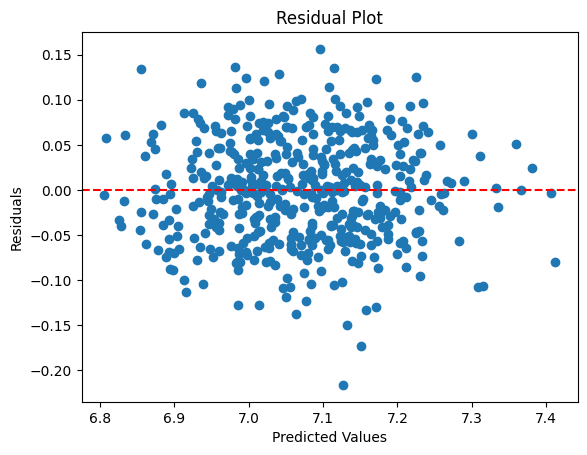

In [35]:
# Get the predicted values
#y_pred_train = lasso.predict(X_train)
y_pred_train = model.fittedvalues

# Calculate the residuals
residuals = model.resid

# Assuming 'y_pred' contains the predicted values and 'residuals' contains the residuals
plt.scatter(y_pred_train, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Creating predicitons for the test data

The same data processing techniques need to be applied to the test data.

In [36]:
# Predictions
df_test = pd.read_csv("data/test.csv")

In [37]:
categorical_cols = df_test.select_dtypes(include=['object']).columns.tolist()
df_test[categorical_cols] = df_test[categorical_cols].fillna(value='A1')

for col in categorical_cols:
    df_test[col] = df_test[col].astype('category')

In [38]:
df_test['Type'] = df_test['Type'].astype('category')

mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'A1':0}

df_test['ExterQual'] = df_test['ExterQual'].map(mapping).replace(mapping).astype('int') # Using map() function
df_test['ExterCond'] = df_test['ExterCond'].map(mapping).replace(mapping).astype('int') # Using map() function
df_test['BsmtQual'] = df_test['BsmtQual'].map(mapping).replace(mapping).astype('int') # Using map() function
df_test['BsmtCond'] = df_test['BsmtCond'].map(mapping).replace(mapping).astype('int') # Using map() function
df_test['FireplaceQu'] = df_test['FireplaceQu'].map(mapping).replace(mapping).astype('int') # Using map() function
df_test['GarageQual'] = df_test['GarageQual'].map(mapping).replace(mapping).astype('int') # Using map() function
df_test['GarageCond'] = df_test['GarageCond'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Ex': 3, 'Gd': 2, 'TA': 1, 'Fa': 0}

df_test['KitchenQual'] = df_test['KitchenQual'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'A1': 0}

df_test['BsmtExposure'] = df_test['BsmtExposure'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'A1': 0}

df_test['BsmtRating'] = df_test['BsmtRating'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Typ': 3, 'Min': 2, 'Mod': 1, 'Maj': 0}

df_test['Functional'] = df_test['Functional'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Fin': 1, 'RFn': 1, 'Unf': 0, 'A1': 0}

df_test['GarageFinish'] = df_test['GarageFinish'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Y': 1, 'N': 0}

df_test['CentralAir'] = df_test['CentralAir'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Attchd': 1, 'Other': 1, 'Detchd': 0, 'A1': 0}

df_test['GarageType'] = df_test['GarageType'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Abnorml': 1, 'Family': 0, 'Normal': 0}

df_test['SaleCondition_Abnorml'] = df_test['SaleCondition'].map(mapping).replace(mapping).astype('int') # Using map() function

mapping = {'Abnorml': 0, 'Family': 1, 'Normal': 0}

df_test['SaleCondition_Family'] = df_test['SaleCondition'].map(mapping).replace(mapping).astype('int') # Using map() function

df_test.drop('SaleCondition', axis=1, inplace=True)

df_test['HasBsmt'] = df_test['BsmtSF'].apply(lambda con: False if con == 0 else True).astype('int')
df_test['HasGarage'] = df_test['GarageCars'].apply(lambda con: False if con == 0 else True).astype('int')
df_test['HasFireplace'] = df_test['Fireplaces'].apply(lambda con: False if con == 0 else True).astype('int')
df_test['HasPool'] = df_test['PoolArea'].apply(lambda con: False if con == 0 else True).astype('int')

df_test['NewArea'] = df_test['BsmtSF'] + df_test['X1stFlrSF'] + df_test['X2ndFlrSF']
df_test['YearBuiltandRemod'] = df_test['YearBuilt'] + df_test['YearRemodAdd']

lambdas_test = []
j=0
for i in num_cols_tranform:
    df_test[i] = stats.boxcox(df_test[i]+1, lambdas[j])
    j = j+ 1

df_test[['YearBuilt','YearRemodAdd','GarageArea','YearBuiltandRemod']] = scaler.fit_transform(
    df_test[['YearBuilt','YearRemodAdd','GarageArea','YearBuiltandRemod']])

categorical_cols = df_test.select_dtypes(include=['category']).columns.tolist()

df_test_dummies = pd.get_dummies(df_test, columns=categorical_cols)

In [39]:
X_test = df_test_dummies.drop(['Id'], axis=1)

X_test[X_test.select_dtypes(include=['bool','category']).columns.tolist()] = X_test[X_test.select_dtypes(
    include=['bool','category']).columns.tolist()].astype(int) 

In [40]:
X_test['OverallQual:SaleCondition_Abnorml'] = X_test['OverallQual'] * X_test['SaleCondition_Abnorml'] 
X_test['NewArea:SaleCondition_Abnorml'] = X_test['NewArea'] * X_test['SaleCondition_Abnorml'] 
X_test['OverallQual:ExterQual'] = X_test['OverallQual'] * X_test['ExterQual'] 
X_test['NewArea:ExterQual'] = X_test['NewArea'] * X_test['ExterQual'] 

X_test = X_test[['NewArea','YearBuiltandRemod','GarageCars','BsmtQual','GarageFinish','KitchenQual','OverallCond','LotArea',
       'BldgType_Twnhs','Zone_RL','Zone_FV','LotConfig_Inside','FireplaceQu','Zone_C','Foundation_PConc',
       'OverallQual:SaleCondition_Abnorml','NewArea:SaleCondition_Abnorml','OverallQual:ExterQual','NewArea:ExterQual']]

In [41]:
y_pred_test = model.predict(sm.add_constant(X_test))

data = {'Id': df_test_dummies['Id'], 'Predicted': y_pred_test}

df_submission = pd.DataFrame(data)

The predicted values need to be trasformed back to the original scale using inverse Box-Cox tranformation with the same lambda that was used for the response variable in the train data.

In [42]:
df_submission['Predicted'] = special.inv_boxcox(df_submission['Predicted'].astype('float'), response_lambda)

df_submission.head()

Id      Predicted
0   57  217581.054286
1  101  275833.257966
2  123  156808.431012
3  145  264281.298803
4  167  212085.157837

In [43]:
df_submission.to_csv('data/submission1.csv', index=False)